# __Desafío - Análisis lineal discriminante__
## Requerimientos
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se
registran las siguientes observaciones:
<ul>
<li><code>default</code>: Variable Binaria. Registra si el cliente entró en morosidad o no.</li>
<li><code>income</code>: Ingreso promedio declarado por el cliente.</li>
<li><code>balance</code>: total del saldo en la cuenta de crédito.</li>
<li><code>student</code>: Variable binaria. Registra si el cliente es estudiante o no.</li>
</ul>


## Ejercicio 1: Preparación de ambiente de trabajo
<ul>
<li>Importe los módulos básicos para el análisis de datos.</li>
<li>Importe las clases <code>LabelEncoder</code>, <code>StandardScaler</code> y <code>LabelBinarizer</code> de
<code>preprocessing</code>.</li>
<li>Importe las funciones <code>train_test_split</code> y <code>cross_val_score</code> de <code>model_selection</code></li>
<li>Importe la función <code>classification_report</code> de <code>metrics</code>.</li>
<li>Importe las clases <code>LinearDiscriminantAnalysis</code> y
<code>QuadraticDiscriminantAnalysis</code>.</li>
<li>Agregue la base de datos en el ambiente de trabajo.</li>
<li>Inspeccione la distribución de cada atributo.</li>
</ul>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [18]:
# Importamos la base de datos
df = pd.read_csv('default_credit.csv').drop(columns=['index'])
print(df.info())
# Guardamos las columnas de estudio
columns = ['student', 'balance', 'income']
df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB
None


,default,student,balance,income
8460,No,Yes,284.841577,20477.837227


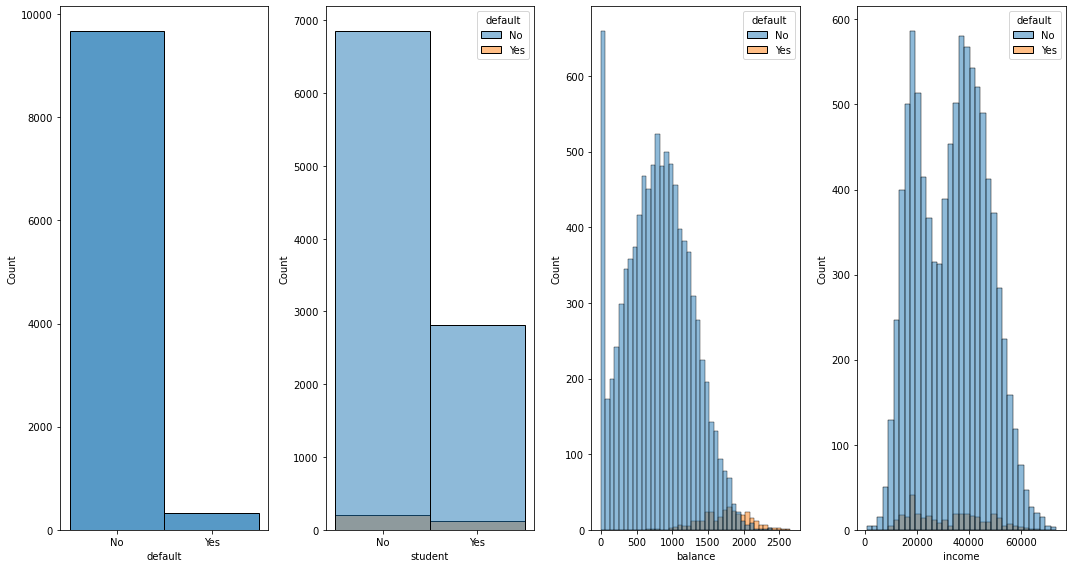

In [16]:
# Creamos los ejes
fig, ax = plt.subplots(1, 4, figsize =(15, 8))
# Graficamos la variable default
sns.histplot(df['default'], ax=ax[0])
# Graficamos el resto de las variables
for i, col in enumerate(columns):
    sns.histplot(x=col, hue='default', data=df, alpha=.5, ax=ax[i + 1])
plt.tight_layout()

## Ejercicio 2: Modelo base
<ul>
<li>Recuerde que los modelos de <code>sklearn</code> no soportan datos que no sean numéricos.
Transforme los atributos pertinentes con <code>LabelEncoder</code>.</li>
<li>Genere muestras de validación y entrenamiento, reservando un 33% de los datos como
validación.</li>
<li>Genere un modelo con <code>LinearDiscriminantAnalysis</code> sin modificar los hiper
parámetros. Genere métricas de evaluación utilizando <code>classification_report</code>.</li>
<li>Comente sobre cuál es el desempeño del modelo en cada clase, así como en general</li>
</ul>

In [21]:
#Instanciamos LabelEncoder
lbl = LabelEncoder()
# Generamos el nuevo dataframe
parsedDf = df.copy()
parsedDf['default'] = lbl.fit_transform(parsedDf['default'])
parsedDf['student'] = lbl.fit_transform(parsedDf['student'])
parsedDf.sample()

,default,student,balance,income
6164,0,1,561.781867,18470.282612


In [23]:
# Generamos los modelos base
X_train, X_test, y_train, y_test = train_test_split(parsedDf.loc[:, 'student' : 'income'], parsedDf['default'], test_size=.33, random_state=19137)
# Entrenamos el modelo
ldaModel = LinearDiscriminantAnalysis()
ldaModel.fit(X_train, y_train)
# Conseguimos las métricas
print(classification_report(y_test, ldaModel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3200
           1       0.86      0.24      0.38       100

    accuracy                           0.98      3300
   macro avg       0.92      0.62      0.68      3300
weighted avg       0.97      0.98      0.97      3300



Vemos que el modelo no tiene problemas para identificar cuando no entra en morosidad, pero sólo acerta un 24% (recall) de los casos en que el cliente entra a morosidad. Vemos claramente que el <code>accuracy</code> está en 98%, pero esto es muy engañoso pues nuesro vector objetivo está fuertemente desbalanceado. 

## Ejercicio 3: Refactorización 1 - información a priori
<ul>
<li>Dado que trabajamos con modelos generativos, podemos incluir información exógena.
Para este caso agregaremos dos distribuciones:
<ul>
<li>Asumamos que hay un 50/50 de morosos y no morosos.</li>
<li>Asumamos que hay un 60/40 de morosos y no morosos.</li>
</ul>
</li>
<li>Por cada modelo, reporte las métricas de clasificación.</li>
</ul>

In [28]:
def ldaWithPriorsReport(trainTuple, testTuple, priors=None, label=''):
    # conseguimos las bases
    X_train_aux, y_train_aux = trainTuple
    X_test_aux, y_test_aux = testTuple
    # Entrenamos el modelo
    ldaModel = LinearDiscriminantAnalysis(priors=priors)
    ldaModel.fit(X_train_aux, y_train_aux)
    # Conseguimos las métricas
    print("="*20 + label + "="*20)
    print(classification_report(y_test_aux, ldaModel.predict(X_test_aux)))
    return ldaModel


In [29]:
ldaWithPriorsReport((X_train, y_train), (X_test, y_test), [.5, .5], 'Modelo 50/50')

====================Modelo 50/50====================
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3200
           1       0.16      0.88      0.28       100

    accuracy                           0.86      3300
   macro avg       0.58      0.87      0.60      3300
weighted avg       0.97      0.86      0.90      3300



LinearDiscriminantAnalysis(priors=[0.5, 0.5])

In [32]:
ldaWithPriorsReport((X_train, y_train), (X_test, y_test), [.4, .6], 'Modelo 40/60')

====================Modelo 40/60====================
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3200
           1       0.13      0.93      0.23       100

    accuracy                           0.81      3300
   macro avg       0.56      0.87      0.56      3300
weighted avg       0.97      0.81      0.87      3300



LinearDiscriminantAnalysis(priors=[0.4, 0.6])

Vemos que en ambos modelos se bajó sustancialmente los falsos negativos de 'default' lo que arroja un <code>recall</code> del ~90% aprox. Sin embargo, la cantidad de falsos positivos aumentó mucho mas, dejando un peor <code>precision</code>  y empeorando en si el modelo debido a la baja del <code>f1-score</code>

## Ejercicio 4: Refactorización 2 - oversampling
### __Digresión: Synthetic Over(Under)Sampling__
<ul>
<li>Por lo general podemos intentar aliviar el problema del desbalance de clases mediante
la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo
dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como
<b>Oversampling</b> cuando repetimos registros aleatorios de la clase minoritaria, y
<b>Undersampling</b> cuando eliminamos aleatoriamente registros de la clase mayoritaria.</li>
<li>Un contratiempo de estos métodos clásicos es que pueden replicar información
sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos,
estaremos replicando estas fallas.</li>
<li>

Otra solución es generar ejemplos de entrenamiento sintéticos mediante el
entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución
funciona de la siguiente forma: En función a un subconjunto de datos correspondientes
a la clase minoritaria, entrenamos algún modelo no supervisado o generativo como
Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de
los datos <b>en el espacio de atributos de la clase específica</b> mediante
$x_{nuevo-ejemplo} = x_i + \lambda(x_{zi} - x_i )$ es un ejemplo de entrenamiento de la clase minoritaria y
$\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim Uniforme(0, 1)$.</li>
<li>Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre
clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic
Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro
ambiente virtual. En nuestro terminal agregamos <code>conda install -c conda-forge
imbalanced-learn</code>. Incorpore SMOTE en el ambiente de trabajo con la siguiente
sintáxis <code>from imblearn.over_sampling import SMOTE</code>.</li>
<li>Para implementar oversampling, debemos generar nuevos objetos que representan
nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente
la siguiente sintaxis:<br>

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```
<br>
</li>
<li>Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente
sobre su desempeño.</li>

</ul>


In [34]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, sampling_strategy='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [41]:
ldaWithPriorsReport((X_train_oversamp, y_train_oversamp), (X_test, y_test), label='Modelo Sin Priors con Oversampling')

====================Modelo Sin Priors con Oversampling====================
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3200
           1       0.17      0.89      0.28       100

    accuracy                           0.86      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.86      0.90      3300



LinearDiscriminantAnalysis()

Vemos que el modelo es casi igual (sólo un pelo mejor) que el modelo sin Oversampling pero con priors de 50/50.

## Ejercicio 5: Refactorización 3 - QDA
<ul>
<li>Por último, implemente un modelo <code>QuadraticDiscriminantAnalysis</code> con los datos
aumentados artificialmente. Genere las métricas de desempeño.</li>
<li>Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.</li>
</ul>


In [42]:
def qdaWithPriorsReport(trainTuple, testTuple, priors=None, label=''):
    # conseguimos las bases
    X_train_aux, y_train_aux = trainTuple
    X_test_aux, y_test_aux = testTuple
    # Entrenamos el modelo
    qdaModel = QuadraticDiscriminantAnalysis(priors=priors)
    qdaModel.fit(X_train_aux, y_train_aux)
    # Conseguimos las métricas
    print("="*20 + label + "="*20)
    print(classification_report(y_test_aux, qdaModel.predict(X_test_aux)))
    return qdaModel

In [44]:
qdaWithPriorsReport((X_train_oversamp, y_train_oversamp), (X_test, y_test), label='Modelo Cuadrático Sin Priors con Oversampling')

====================Modelo Cuadrático Sin Priors con Oversampling====================
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3200
           1       0.19      0.86      0.32       100

    accuracy                           0.89      3300
   macro avg       0.59      0.87      0.63      3300
weighted avg       0.97      0.89      0.92      3300



QuadraticDiscriminantAnalysis()

Vemos que las estadísticas de este modelo son mejores que los anteriormente definidos con la excepción del primero. El mejor modelo dependerá de la tolerancia al error que podamos soportar como investigadores, pues el primer modelo es mucho mejor prediciendo cuando no es moroso pero tiene una tasa baja de acertar a la predicción de los morosos. Por otro lado este último modelo es mejor acertando cuando un cliente será moroso pero genera muchos mas falsos positivos, por tanto, empeorando un tanto la predicción de cuando no se es moroso.